# Install Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
# from pandas_datareader import data as pdr
# import fix_yahoo_finance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

You should consider upgrading via the 'c:\users\ritik\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Fetch the data

In [6]:
df_full = pd.read_csv("https://raw.githubusercontent.com/johmn123-wq/Stock-Prediction/main/INFY.csv")
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/1/2020,13.84,13.90,13.71,13.76,13.472431,5418500
1,10/2/2020,13.69,13.74,13.57,13.67,13.384312,7740400
2,10/5/2020,14.17,14.20,14.02,14.05,13.756370,10194400
3,10/6/2020,14.14,14.19,13.89,13.89,13.599713,11187800
4,10/7/2020,14.31,14.58,14.29,14.54,14.236129,18332700


# Define the Q learning agent

In [7]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))




# Train the agent


In [8]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, window_size = window_size, trend = close, skip = skip,  batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

c:\users\ritik\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\ritik\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 3.819996.3, cost: 0.002365, total money: 10003.819996
epoch: 20, total rewards: 3.919995.3, cost: 0.002341, total money: 10003.919995
epoch: 30, total rewards: 4.129995.3, cost: 0.002317, total money: 10004.129995
epoch: 40, total rewards: 3.959995.3, cost: 0.002295, total money: 10003.959995
epoch: 50, total rewards: 2.049995.3, cost: 0.002279, total money: 10002.049995
epoch: 60, total rewards: 5.289996.3, cost: 0.002248, total money: 10005.289996
epoch: 70, total rewards: 3.649997.3, cost: 0.002172, total money: 10003.649997
epoch: 80, total rewards: 3.389994.3, cost: 0.002213, total money: 10003.389994
epoch: 90, total rewards: 4.129994.3, cost: 0.002192, total money: 10004.129994
epoch: 100, total rewards: 4.519994.3, cost: 0.002115, total money: 10004.519994
epoch: 110, total rewards: 3.749996.3, cost: 0.002155, total money: 10003.749996
epoch: 120, total rewards: 4.199992.3, cost: 0.002649, total money: 10004.199992
epoch: 130, total rewards: 1.689994.3

# Testing the agent 


In [9]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 13.670000, total balance 9986.330000
day 3, sell 1 unit at price 13.890000, investment 1.609364 %, total balance 10000.220000,
day 10: buy 1 unit at price 15.260000, total balance 9984.960000
day 11, sell 1 unit at price 15.510000, investment 1.638270 %, total balance 10000.470000,
day 12: buy 1 unit at price 15.140000, total balance 9985.330000
day 13, sell 1 unit at price 15.370000, investment 1.519155 %, total balance 10000.700000,
day 17: buy 1 unit at price 14.920000, total balance 9985.780000
day 18, sell 1 unit at price 14.850000, investment -0.469169 %, total balance 10000.630000,
day 22: buy 1 unit at price 14.250000, total balance 9986.380000
day 23, sell 1 unit at price 14.300000, investment 0.350877 %, total balance 10000.680000,
day 24: buy 1 unit at price 14.680000, total balance 9986.000000
day 25, sell 1 unit at price 15.010000, investment 2.247956 %, total balance 10001.010000,
day 31: buy 1 unit at price 15.290000, total balance 9985.720000


day 183, sell 1 unit at price 21.190001, investment 2.515728 %, total balance 10005.159997,
day 186: buy 1 unit at price 21.450001, total balance 9983.709996
day 187: buy 1 unit at price 21.190001, total balance 9962.519995
day 188, sell 1 unit at price 20.959999, investment -2.284392 %, total balance 9983.479994,
day 189, sell 1 unit at price 21.070000, investment -0.566310 %, total balance 10004.549994,
day 191: buy 1 unit at price 21.180000, total balance 9983.369994
day 192: buy 1 unit at price 20.950001, total balance 9962.419993
day 193, sell 1 unit at price 21.340000, investment 0.755430 %, total balance 9983.759993,
day 194: buy 1 unit at price 21.049999, total balance 9962.709994
day 195, sell 1 unit at price 21.049999, investment 0.477317 %, total balance 9983.759993,
day 196, sell 1 unit at price 21.389999, investment 1.615202 %, total balance 10005.149992,
day 197: buy 1 unit at price 21.129999, total balance 9984.019993
day 198: buy 1 unit at price 20.860001, total balance

# Plot the calls

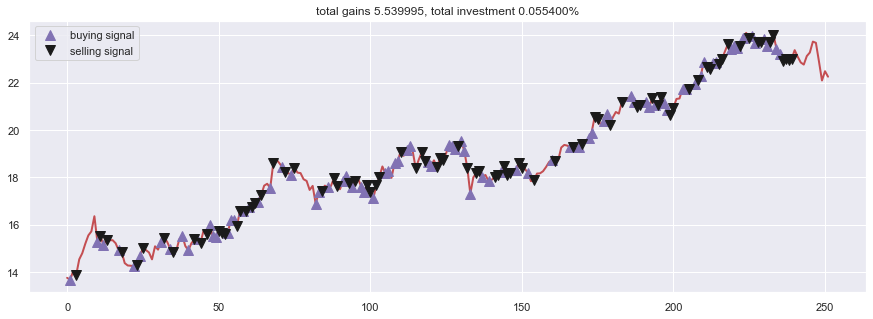

In [11]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()